In [5]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [01:21<00:00, 23.6MB/s]
100% 1.76G/1.76G [01:21<00:00, 23.2MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/lung-and-colon-cancer-histopathological-images.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [7]:
DATADIR = '/content/lung_cancer'
CATEGORIES = ['lung_squamous_cell_carcinomos','lung_normal', 'lung_adenocarcinomas']

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

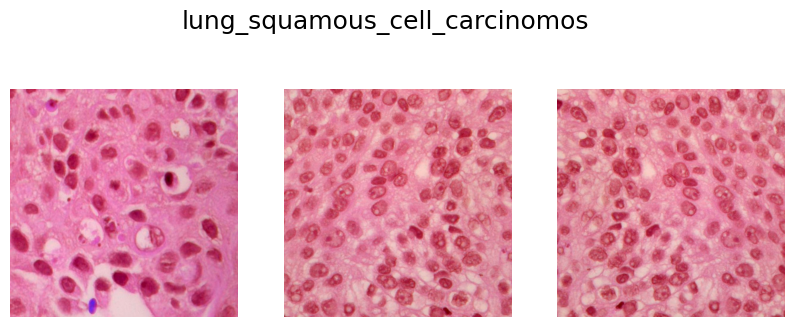

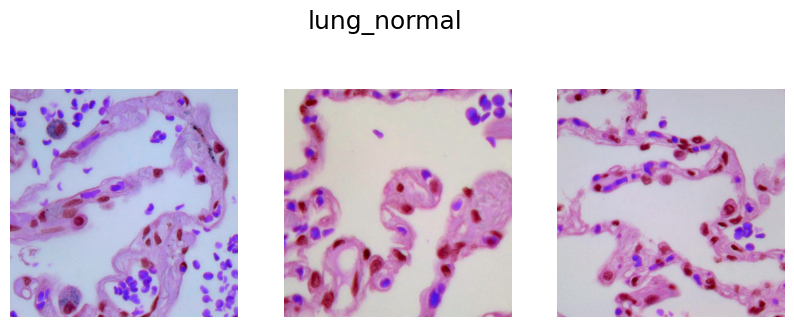

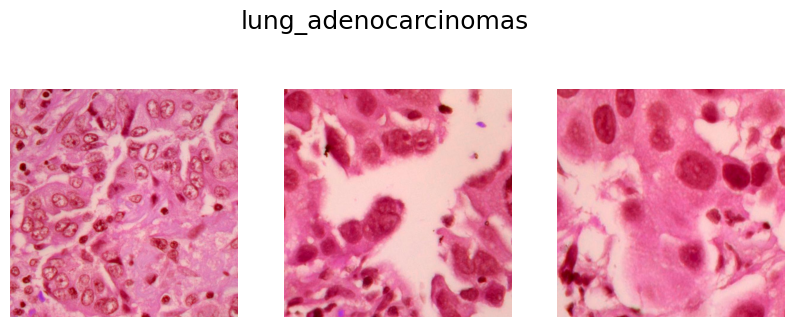

In [9]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  images =  os.listdir(path)

  fig, ax = plt.subplots(1,3, figsize=(10,4))
  fig.suptitle(f'{category}',fontsize=18)
  for i in range(3):
    img_name = images[np.random.randint(0,len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)
    ax[i].imshow(img_array)
    ax[i].axis('off')

In [10]:
img_array.shape

(768, 768, 3)

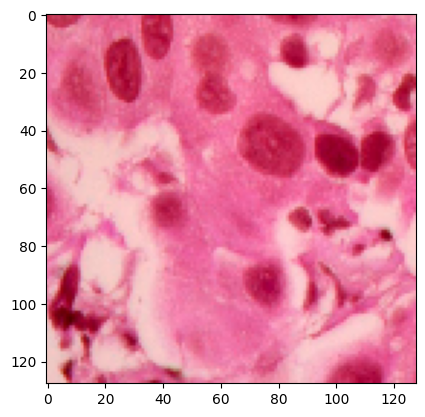

In [11]:
IMG_SIZE = 128
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [12]:
#creating training data
training_data = []
def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labes = CATEGORIES.index(category) # constructing the path
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labes])
      except Exception as e:
        pass
create_training_data()

In [13]:
len(training_data)

15000

In [14]:
x = []
y = []

for features, label in training_data:
  x.append(features)
  y.append(label)

x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [15]:
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
print(f'x_train Length:{x_train.shape[0]},{x_train.shape[1:3]}')
print(f'x_test Length:{x_test.shape[0]},{x_test.shape[1:3]}')
print(f'y_train Length:{y_train.shape[0]}')
print(f'y_test Length:{y_test.shape[0]}')

x_train Length:12000,(128, 128)
x_test Length:3000,(128, 128)
y_train Length:12000
y_test Length:3000


In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16

In [19]:
vgg =vgg16.VGG16(weights='imagenet',include_top = False,input_shape=(128,128,3))

58889256/58889256 [==============================] - 4s 0us/step


In [20]:
#freezing the layers
for layer in vgg.layers:
  layer.trainable = False

In [21]:
#adding top layer
model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit(x_train,y_train, epochs=5)

Epoch 1/5
375/375 [==============================] - 21s 38ms/step - loss: 0.3917 - accuracy: 0.9248
Epoch 2/5
375/375 [==============================] - 15s 39ms/step - loss: 0.0892 - accuracy: 0.9648
Epoch 3/5
375/375 [==============================] - 15s 40ms/step - loss: 0.0734 - accuracy: 0.9701
Epoch 4/5
375/375 [==============================] - 16s 42ms/step - loss: 0.0497 - accuracy: 0.9800
Epoch 5/5
375/375 [==============================] - 15s 41ms/step - loss: 0.0425 - accuracy: 0.9841


In [34]:
loss,accuracy = model.evaluate(x_test, y_test)
print(f'accuracy: {accuracy*100}')

94/94 [==============================] - 4s 42ms/step - loss: 0.0868 - accuracy: 0.9693
accuracy: 96.93333506584167


In [33]:
pred = np.argmax(model.predict(x_test),axis=1)
print(pred)

94/94 [==============================] - 4s 44ms/step
[2 1 2 ... 2 2 0]


In [36]:
y_test[:5]

array([2, 1, 2, 0, 1])

In [35]:
pred[:5]

array([2, 1, 2, 0, 1])

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1037
           1       1.00      1.00      1.00       970
           2       0.97      0.93      0.95       993

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [38]:
cf = confusion_matrix(y_test, pred,normalize='true')
print(cf)

[[0.975892   0.         0.024108  ]
 [0.         0.99896907 0.00103093]
 [0.06646526 0.         0.93353474]]


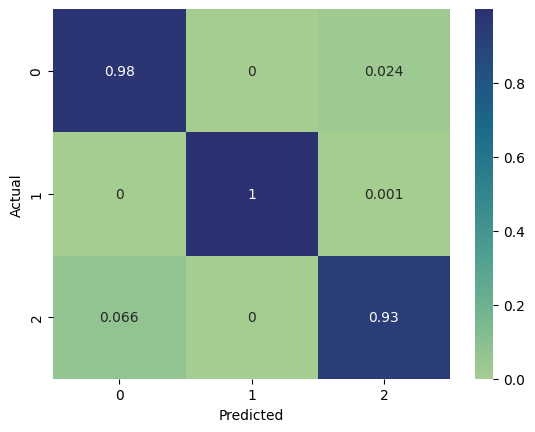

In [40]:
import seaborn as sns
sns.heatmap(cf, annot=True,cmap= 'crest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()